In [1]:
import numpy                as np

import matplotlib.pyplot    as plt
import matplotlib.animation as animation
import  matplotlib.colors   as  col
import matplotlib           as mpl

# Setup plot settings
mpl.rcParams['figure.dpi'] = 300
plt.rcParams["animation.html"] = "jshtml"

In [2]:
class Lattice():

    def __init__(self, n_size):
        'Initialize the lattice'

        # Size of lattice
        self.n_size = n_size

        # Initialize the lattice
        self.lattice = 2 * np.random.randint(2, size = (n_size,) * 2) - 1

        # Keep track of the original lattice
        self.lattice_org = self.lattice
        self.n_size_org = n_size

        # Initial size
        self.n_size_init = 4

        return
    
    def show_lattice(self):
        'Display current state of lattice'

        # Setup plots
        fig, ax = plt.subplots()
        fig.tight_layout()

        # Define color legend
        color_dict = {0: '#2D4263', 1: '#C84B31'}
        label_dict = {0: 'off', 1: 'on'}
        imax = max(label_dict)
        imin = min(label_dict)
        cmap = col.ListedColormap(color_dict.values())

        # Display lattice
        mat = ax.matshow(self.lattice, cmap=cmap, interpolation="nearest", vmin=imin, vmax=imax)
        
        # Display colorbar
        cbar = fig.colorbar(mat, ticks = [0,1])
        cbar.ax.set_yticklabels(['-1', '+1'])
    
        # Show grid (small lines)
        ax.vlines(x=[k-0.5 for k in range(self.n_size)], color="black", ymin=-0.5, ymax=self.n_size - 0.5, alpha=0.25, linestyles="-", linewidth=0.5)
        ax.hlines(y=[k-0.5 for k in range(self.n_size)], color="black", xmin=-0.5, xmax=self.n_size - 0.5, alpha=0.25, linestyles="-", linewidth=0.5)
        # Show grid (big lines)
        lines = [k-0.5 for k in range(0, self.n_size, self.n_size // self.n_size_init)]
        ax.vlines(x=lines, color="black", ymin=-0.5, ymax=self.n_size - 0.5, alpha=0.5)
        ax.hlines(y=lines, color="black", xmin=-0.5, xmax=self.n_size - 0.5, alpha=0.5)
        # Disable axes
        ax.axis('off')

        # Show final plot
        plt.show()

        return
    
    def montecarlo(self, n_steps, temperature):
        'Perform Monte-Carlo simulation steps on lattice'

        # Magnetization and energy
        self.magnetization = np.zeros(n_steps)
        self.energy =np.zeros((n_steps, self.n_size, self.n_size))

        # Initial magnetization and energy
        self.magnetization[0] = np.sum(self.lattice)
        self.energy[0] = -np.sum(self.lattice*np.roll(self.lattice, 1, axis=0) + self.lattice*np.roll(self.lattice, 1, axis=1))

        # Define temperature
        beta = 1/temperature

        # Perform Monte-Carlo steps
        for i in range(1, n_steps):

            # Select a random spin
            x = np.random.randint(self.n_size)
            y = np.random.randint(self.n_size)

            # Flip the spin
            self.lattice[x,y] *= -1

            # Check if transformation is compatible
            if np.sign(np.sum(self.lattice[x//2*2:x//2*2+2, y//2*2:y//2*2+2])) == np.sign(self.lattice_org[x//2, y//2]):
                # Compatible
                self.lattice[x,y] *= -1

            elif np.sum(self.lattice[x//2*2:x//2*2+2, y//2*2:y//2*2+2]) == 0:
                # Randomly choose if compatible or not
                self.lattice[x,y] *= -1
                if np.random.choice([True, False]):
                    pass
                else:
                    # Update magnetization and energy
                    self.magnetization[i] = self.magnetization[i-1]
                    self.energy[i] = self.energy[i-1]
                    continue

            elif np.sign(np.sum(self.lattice[x//2*2:x//2*2+2, y//2*2:y//2*2+2])) != np.sign(self.lattice_org[x//2,y//2]):
                self.lattice[x,y] *= -1
                # Update magnetization and energy
                self.magnetization[i] = self.magnetization[i-1]
                self.energy[i] = self.energy[i-1]
                continue

            # Calculate the change in energy
            energy = 2 * self.lattice[x, y] * (self.lattice[(x+1) % self.n_size, y] 
                       + self.lattice[(x-1) % self.n_size, y] 
                       + self.lattice[x, (y+1) % self.n_size] 
                       + self.lattice[x, (y-1) % self.n_size])

            # Flip spin (or not)
            if energy < 0 or np.random.rand() < np.exp(-beta*energy):
                self.lattice[x,y] *= -1
                # Update magnetization and energy
                self.magnetization[i] = self.magnetization[i-1] + 2*self.lattice[x,y]
                self.energy[i] = self.energy[i-1] + energy
            else:
                # Update magnetization and energy
                self.magnetization[i] = self.magnetization[i-1]
                self.energy[i] = self.energy[i-1]

        # Write magnetization and energy for last iteration
        # print("Magnetization {}\t Energy {}".format(self.magnetization[-1], np.unique(self.energy[-1])))

        return
    
    def renorm(self):
        'Renormalize lattice to higher dimension'

        # New size
        n_size_new = self.n_size * 2
        # Initialize new lattice
        lattice_new = 2 * np.random.randint(2, size = (n_size_new,) * 2) - 1

        # Ensure new lattice has same values as old
        for i in range(self.n_size):
            for j in range(self.n_size):
                # This can be simplified I think
                lattice_new[2*i, 2*j] = self.lattice[i,j]
                lattice_new[2*i+1, 2*j] = self.lattice[i,j]
                lattice_new[2*i, 2*j+1] = self.lattice[i,j]
                lattice_new[2*i+1, 2*j+1] = self.lattice[i,j]

        # Save current lattice as previous
        self.lattice_org = self.lattice
        self.n_size_org = self.n_size

        # Set lattice to the new, renormalized lattice
        self.lattice = lattice_new
        self.n_size = n_size_new

        return

In [3]:
# Simulation parameters
mc_steps = 10000
temperature = 2.269
size_init = 4

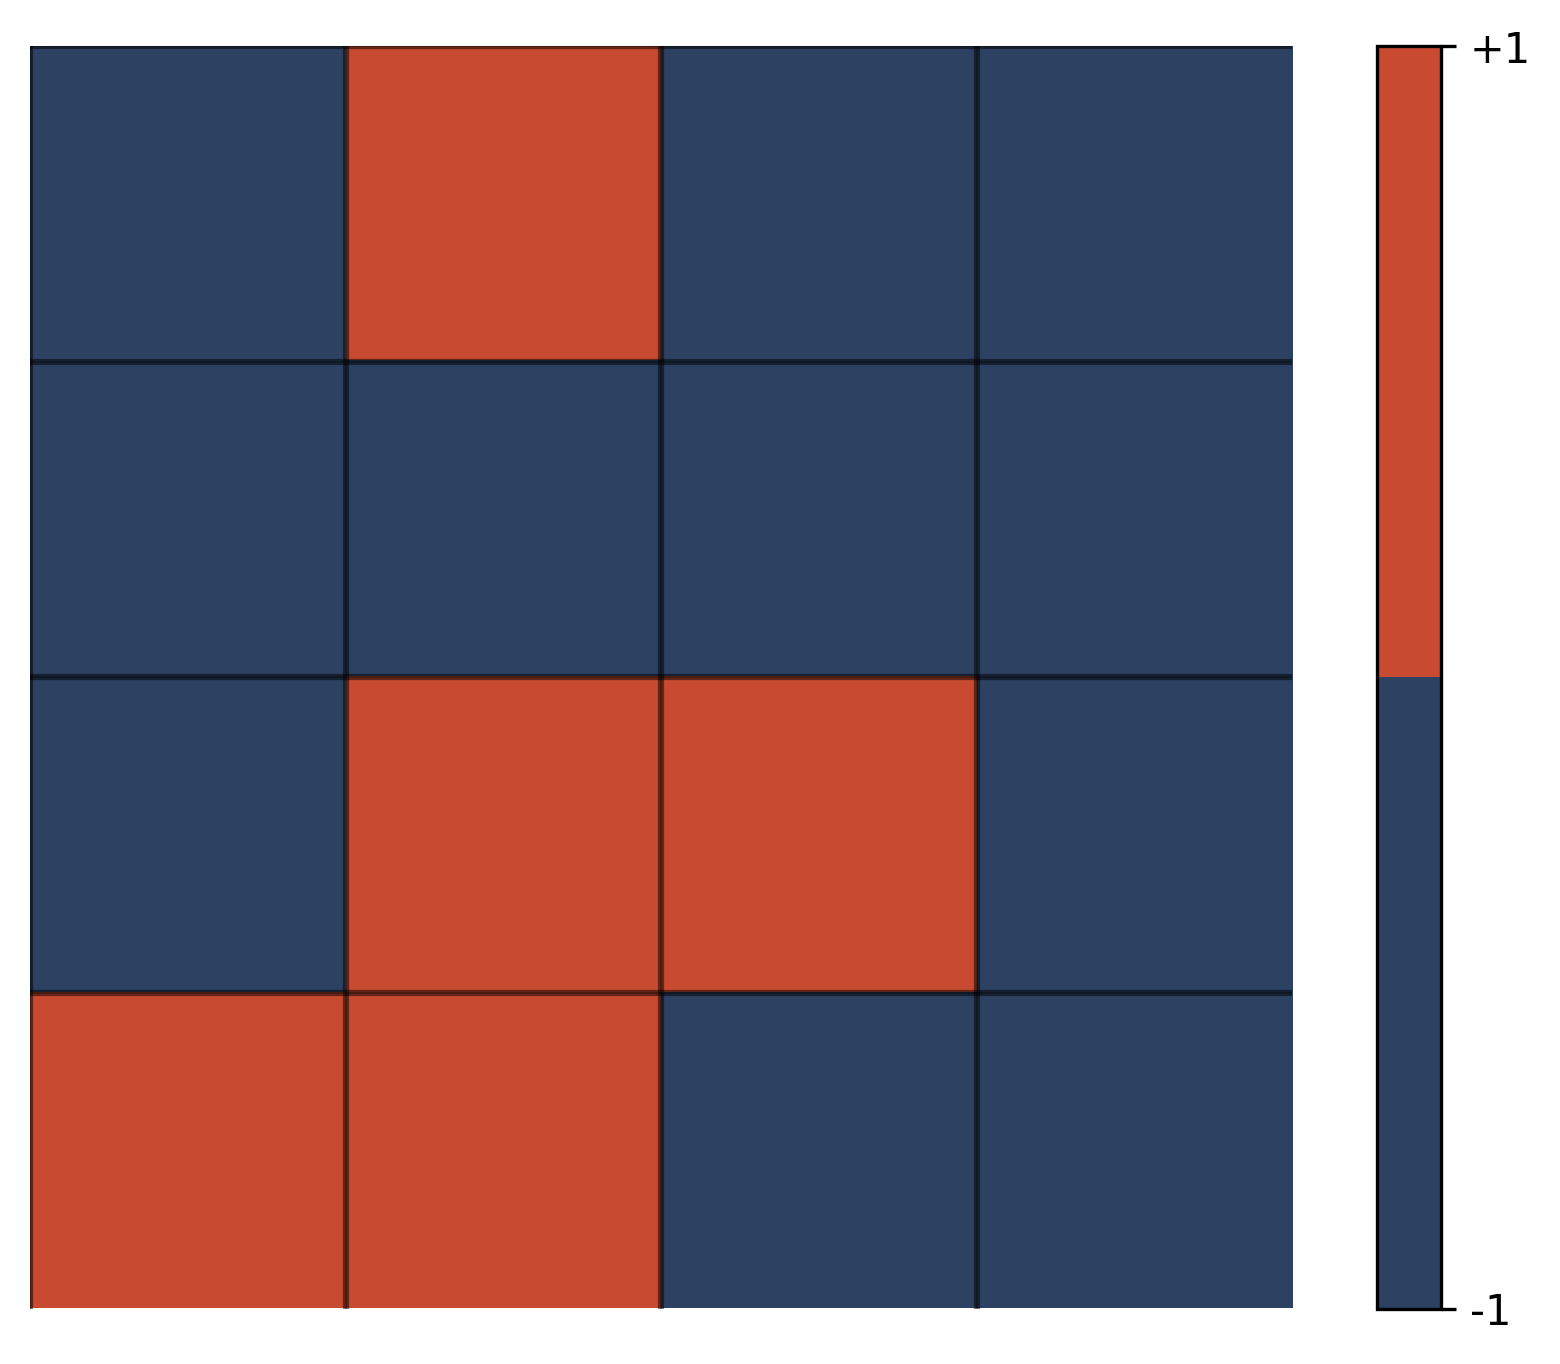

In [4]:
lattice = Lattice(n_size = size_init)
# Show lattice
lattice.show_lattice()

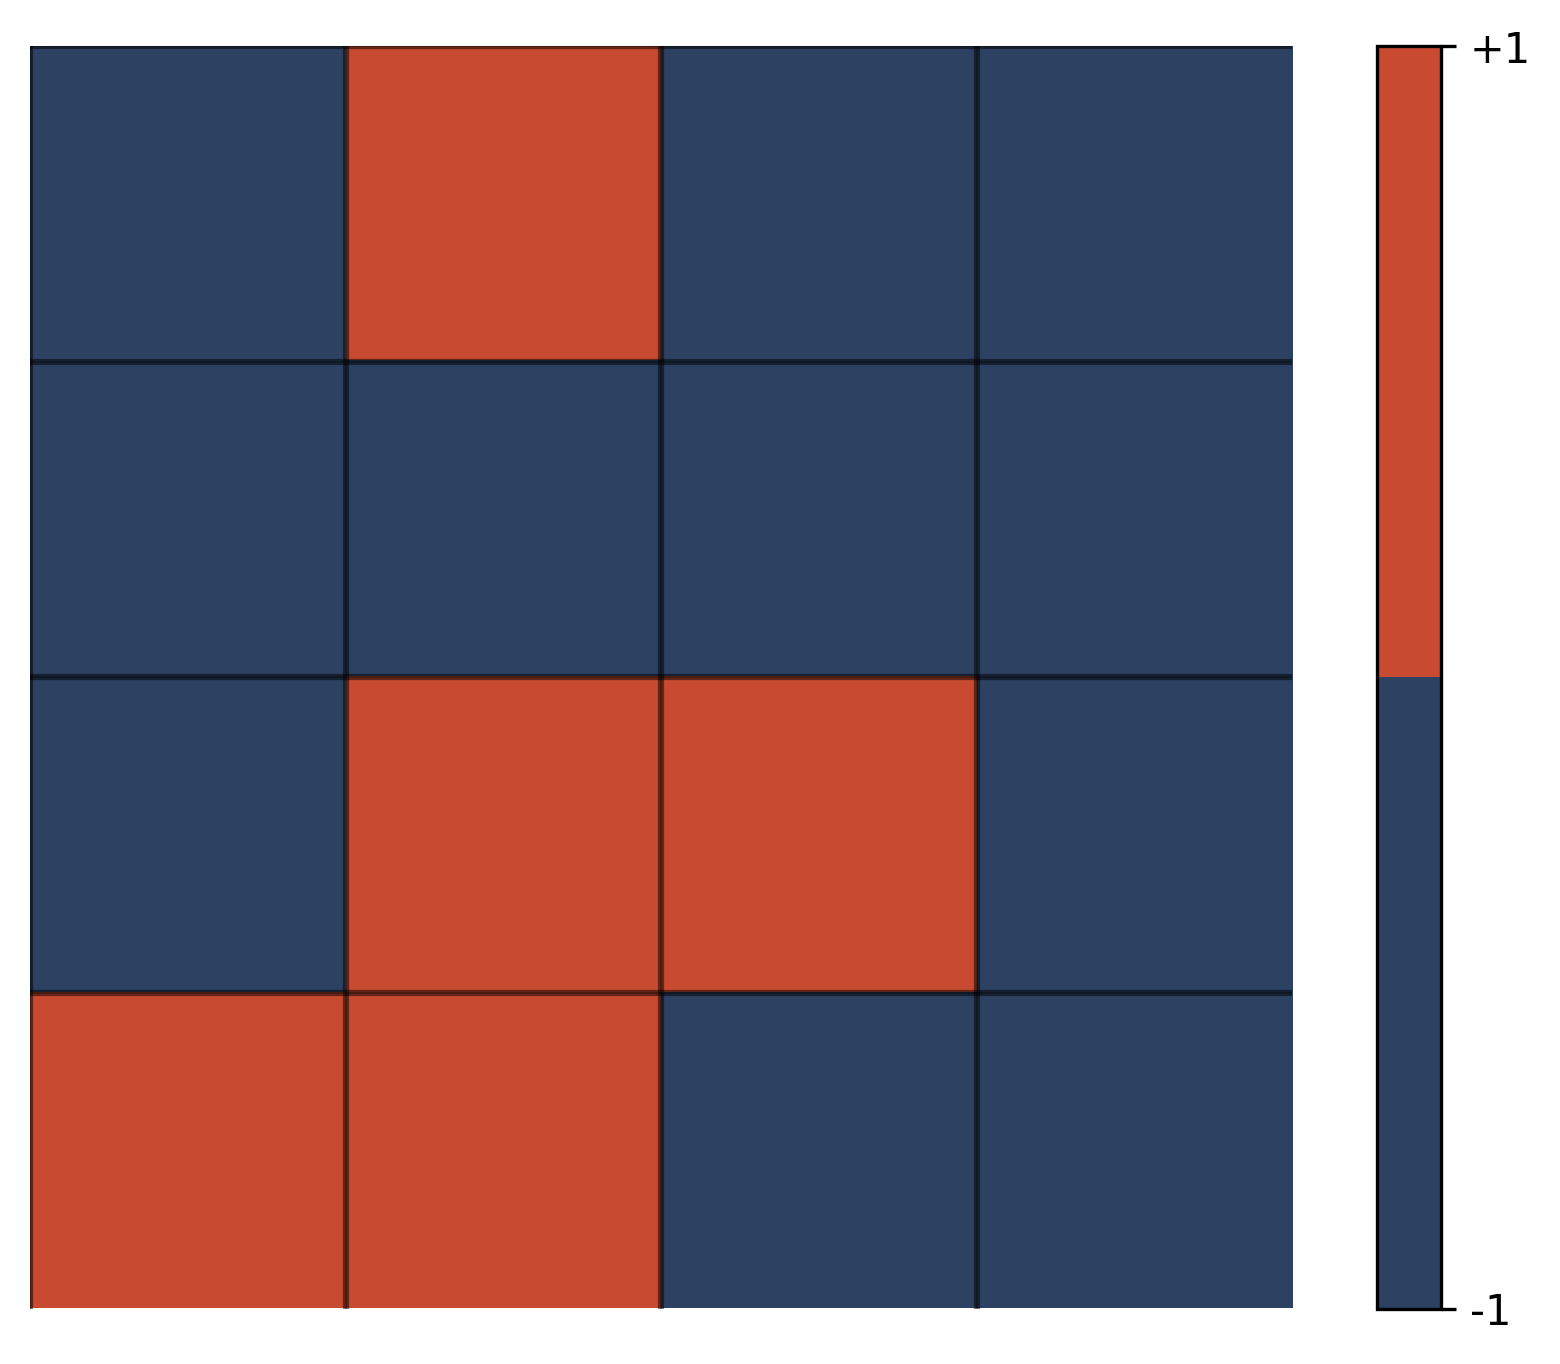

In [5]:
lattice.show_lattice()

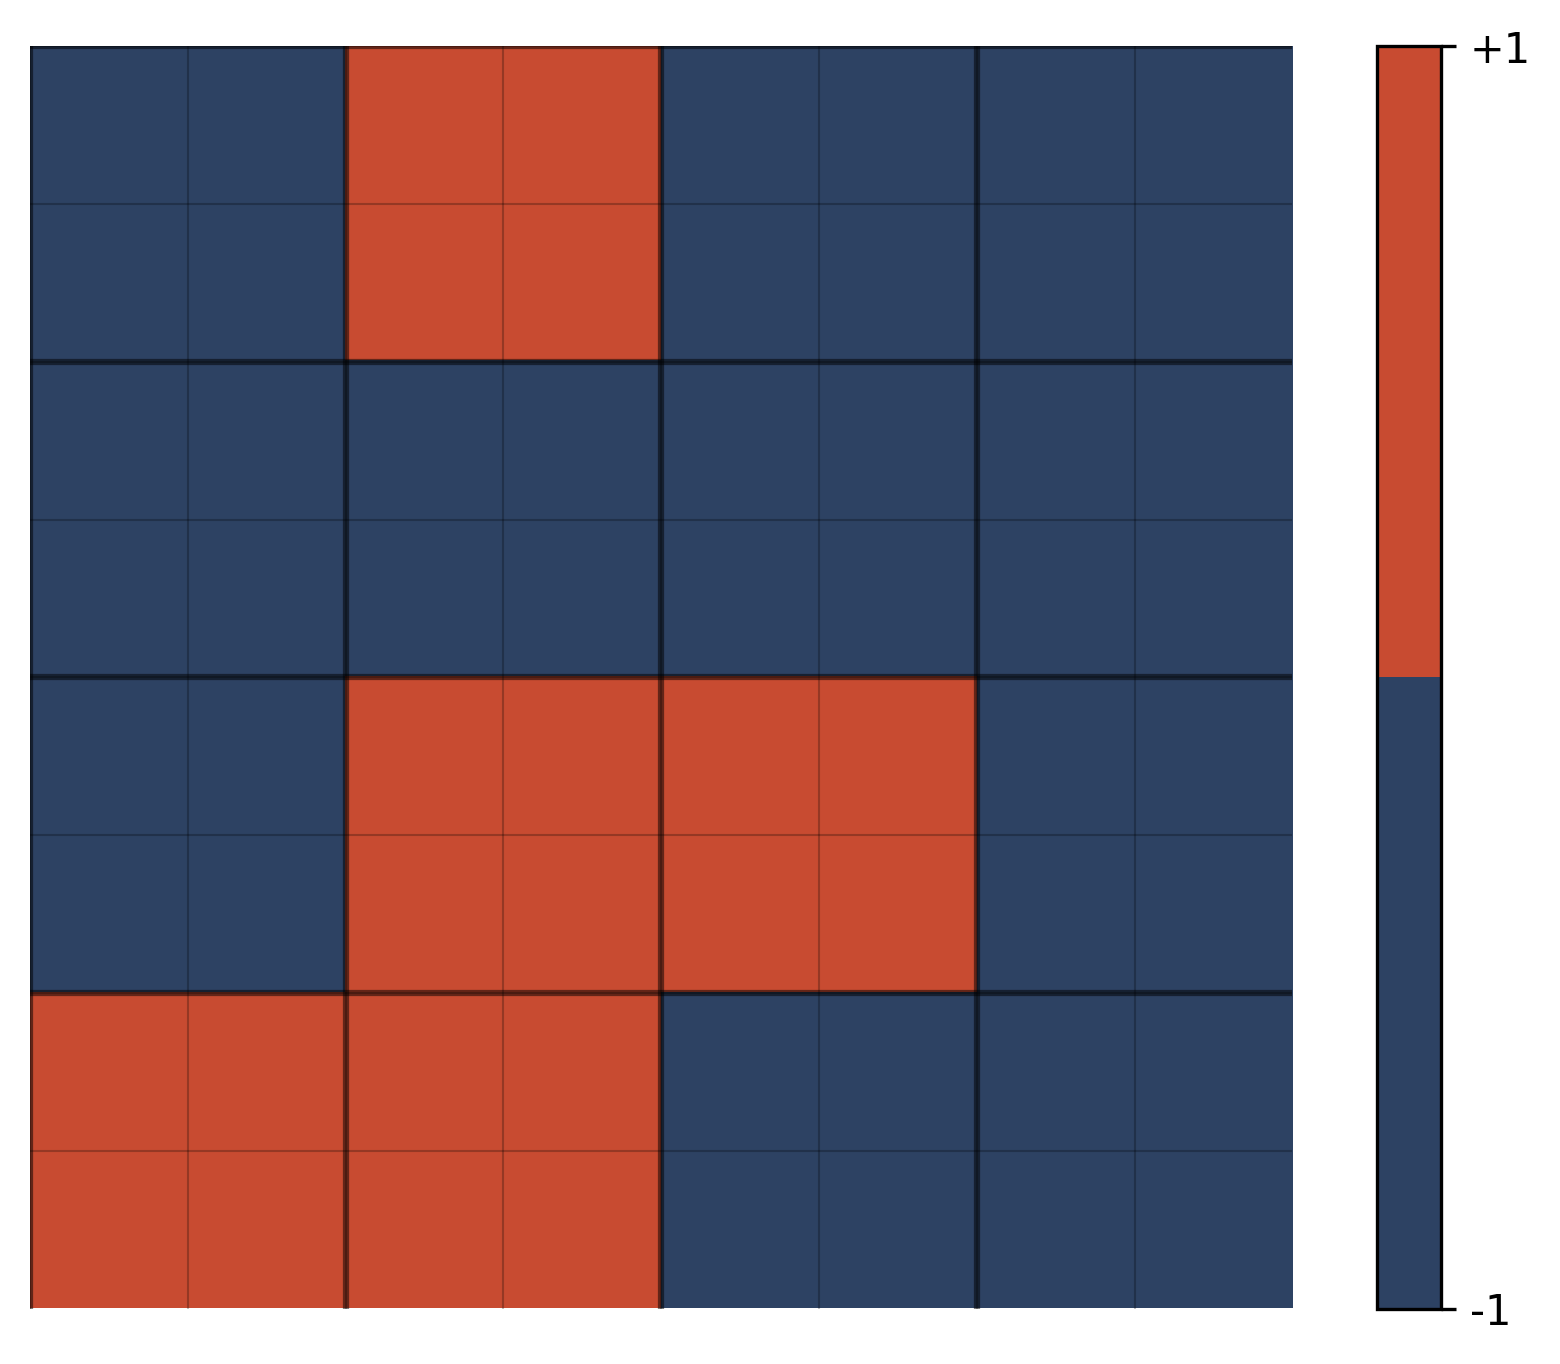

In [6]:
lattice.renorm()
lattice.show_lattice()

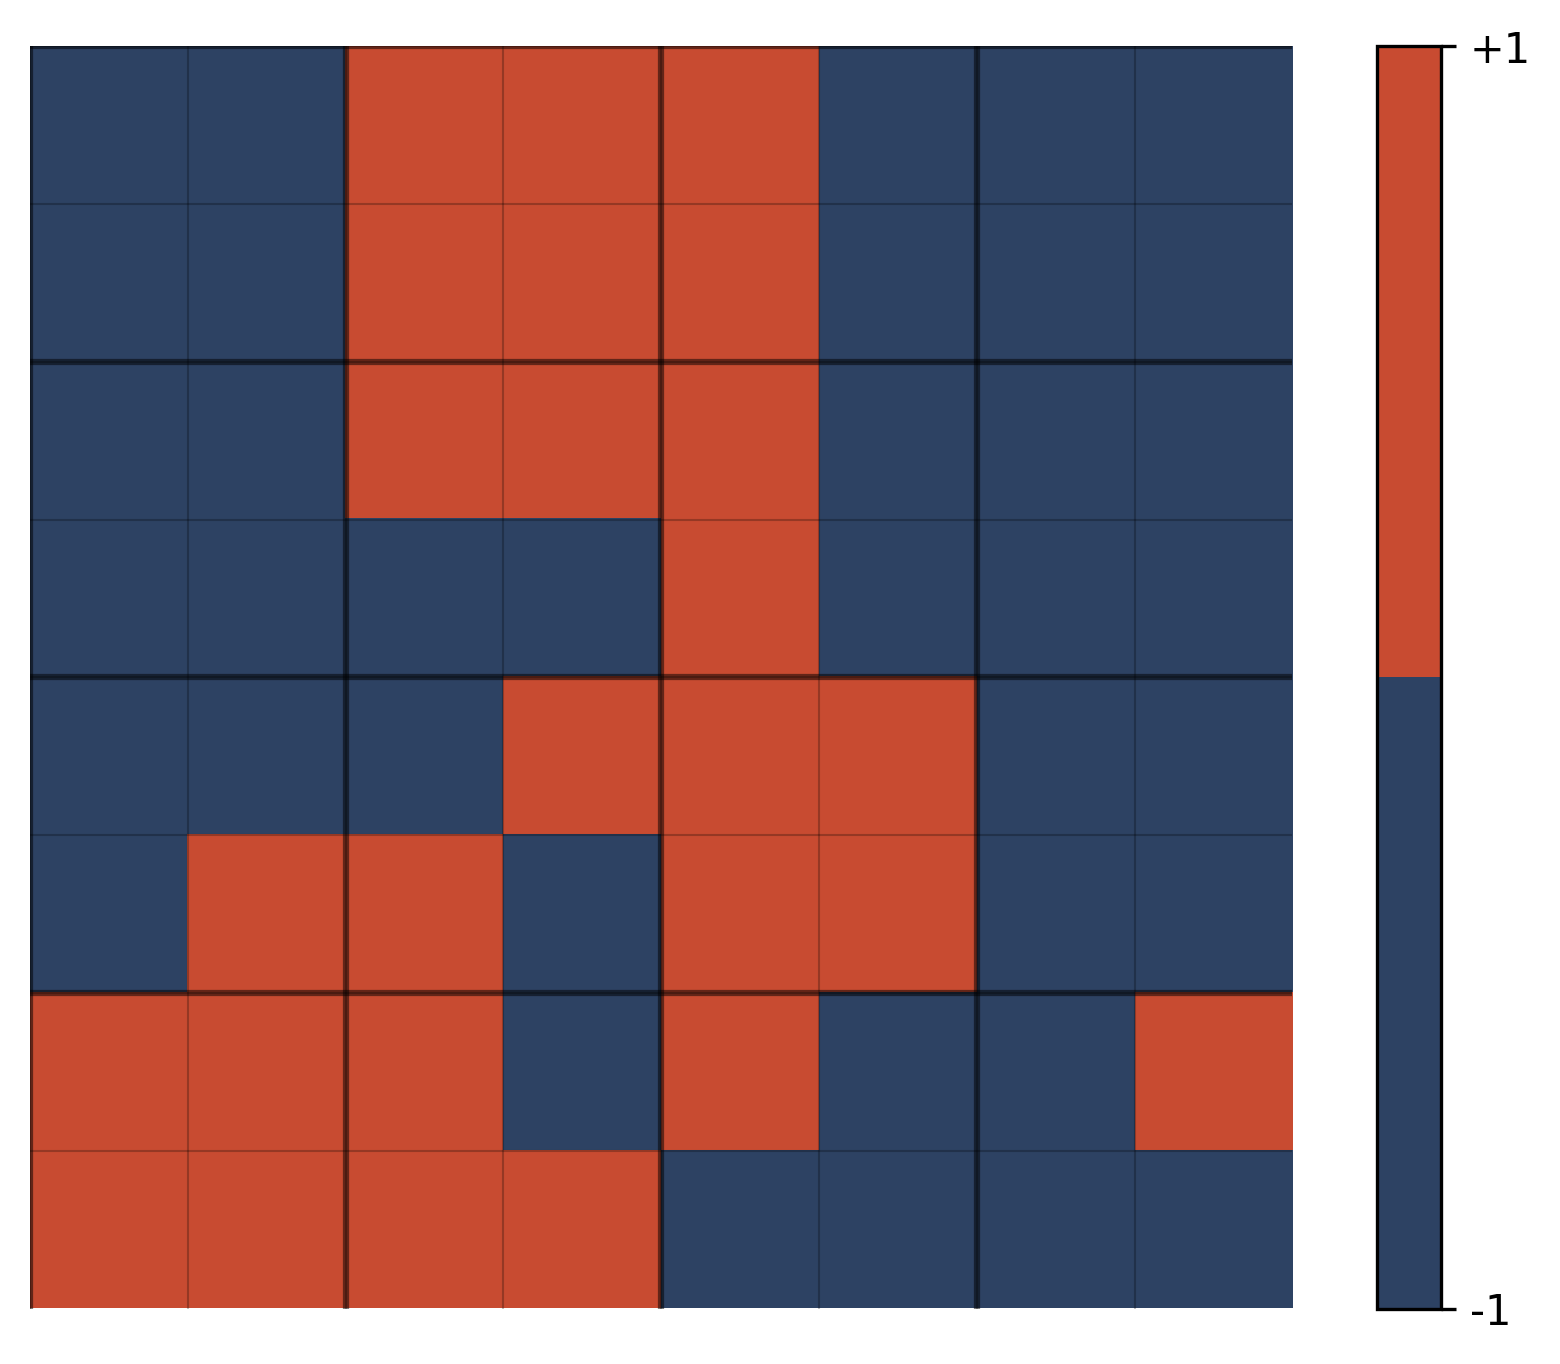

In [7]:
lattice.montecarlo(mc_steps, temperature)
lattice.show_lattice()

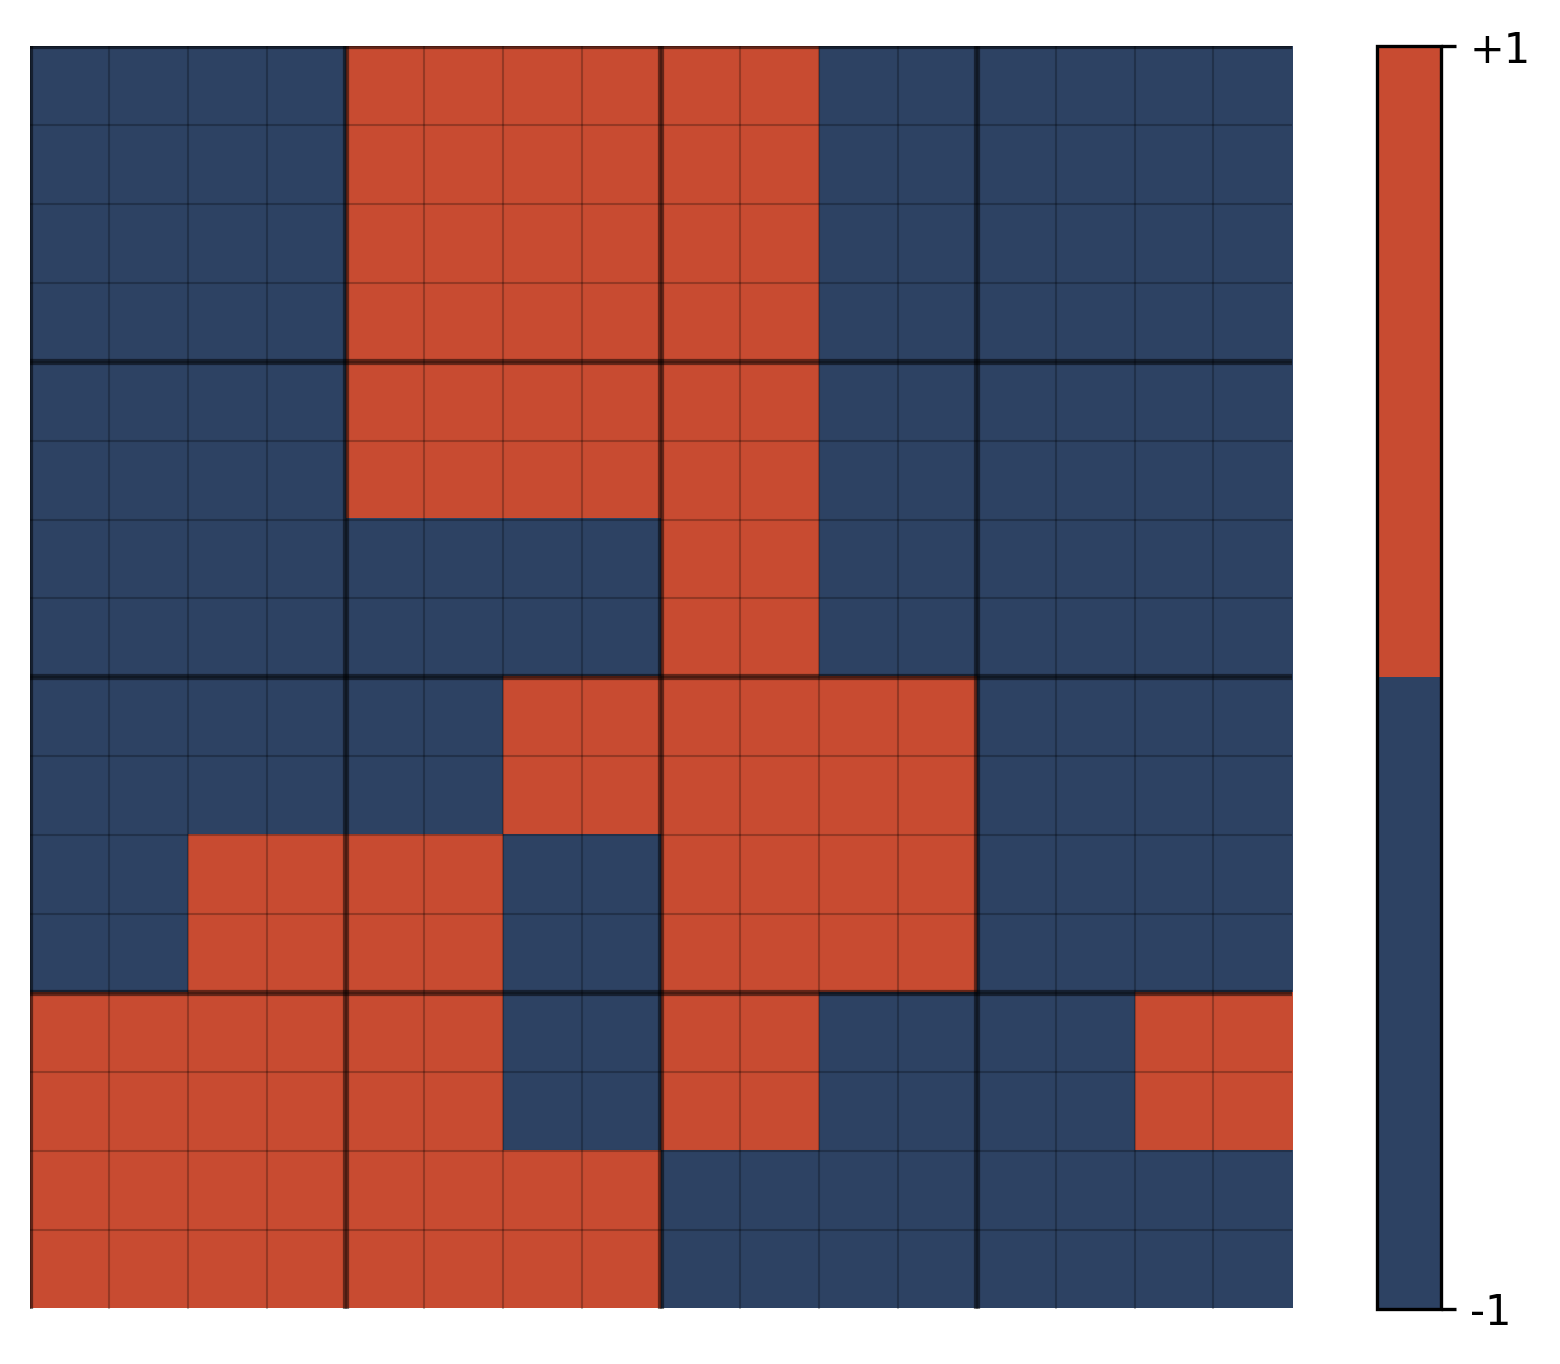

In [8]:
lattice.renorm()
lattice.show_lattice()

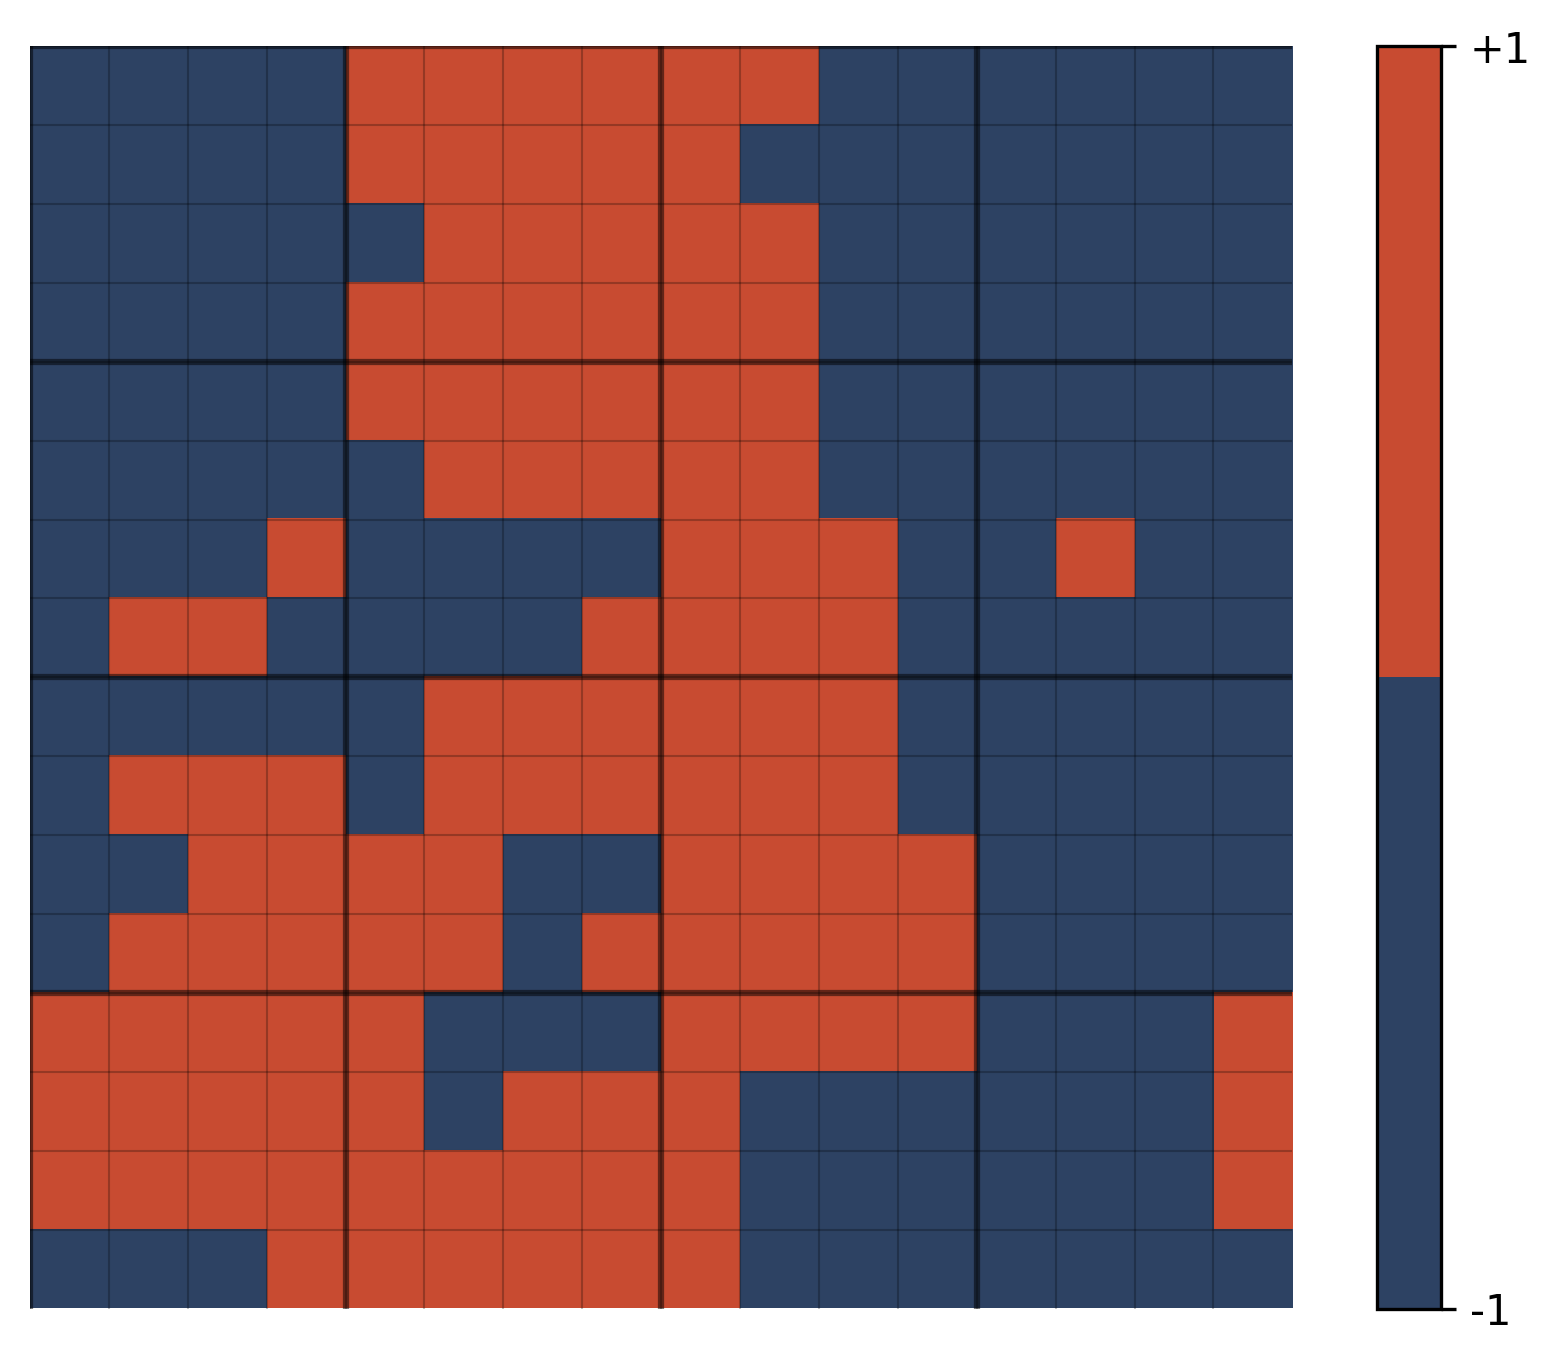

In [9]:
lattice.montecarlo(mc_steps, temperature)
lattice.show_lattice()

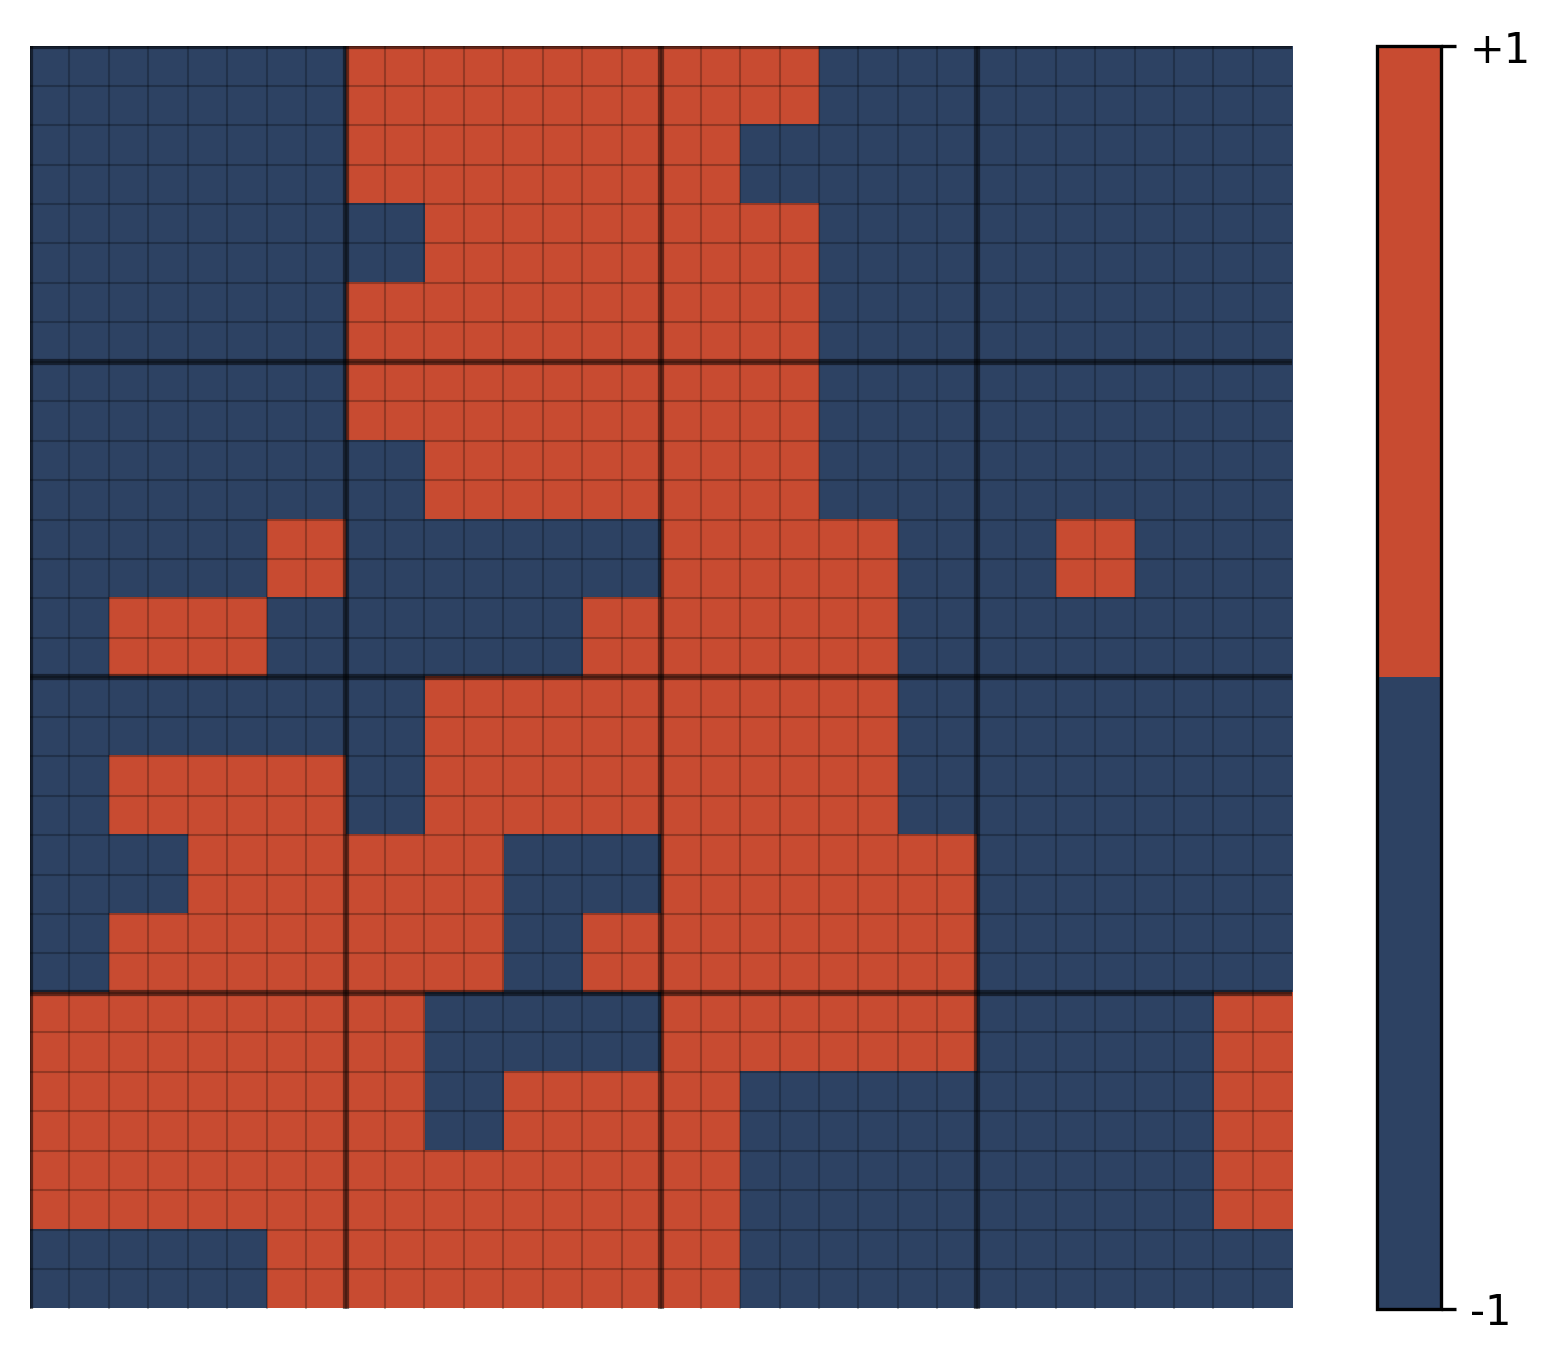

In [10]:
lattice.renorm()
lattice.show_lattice()

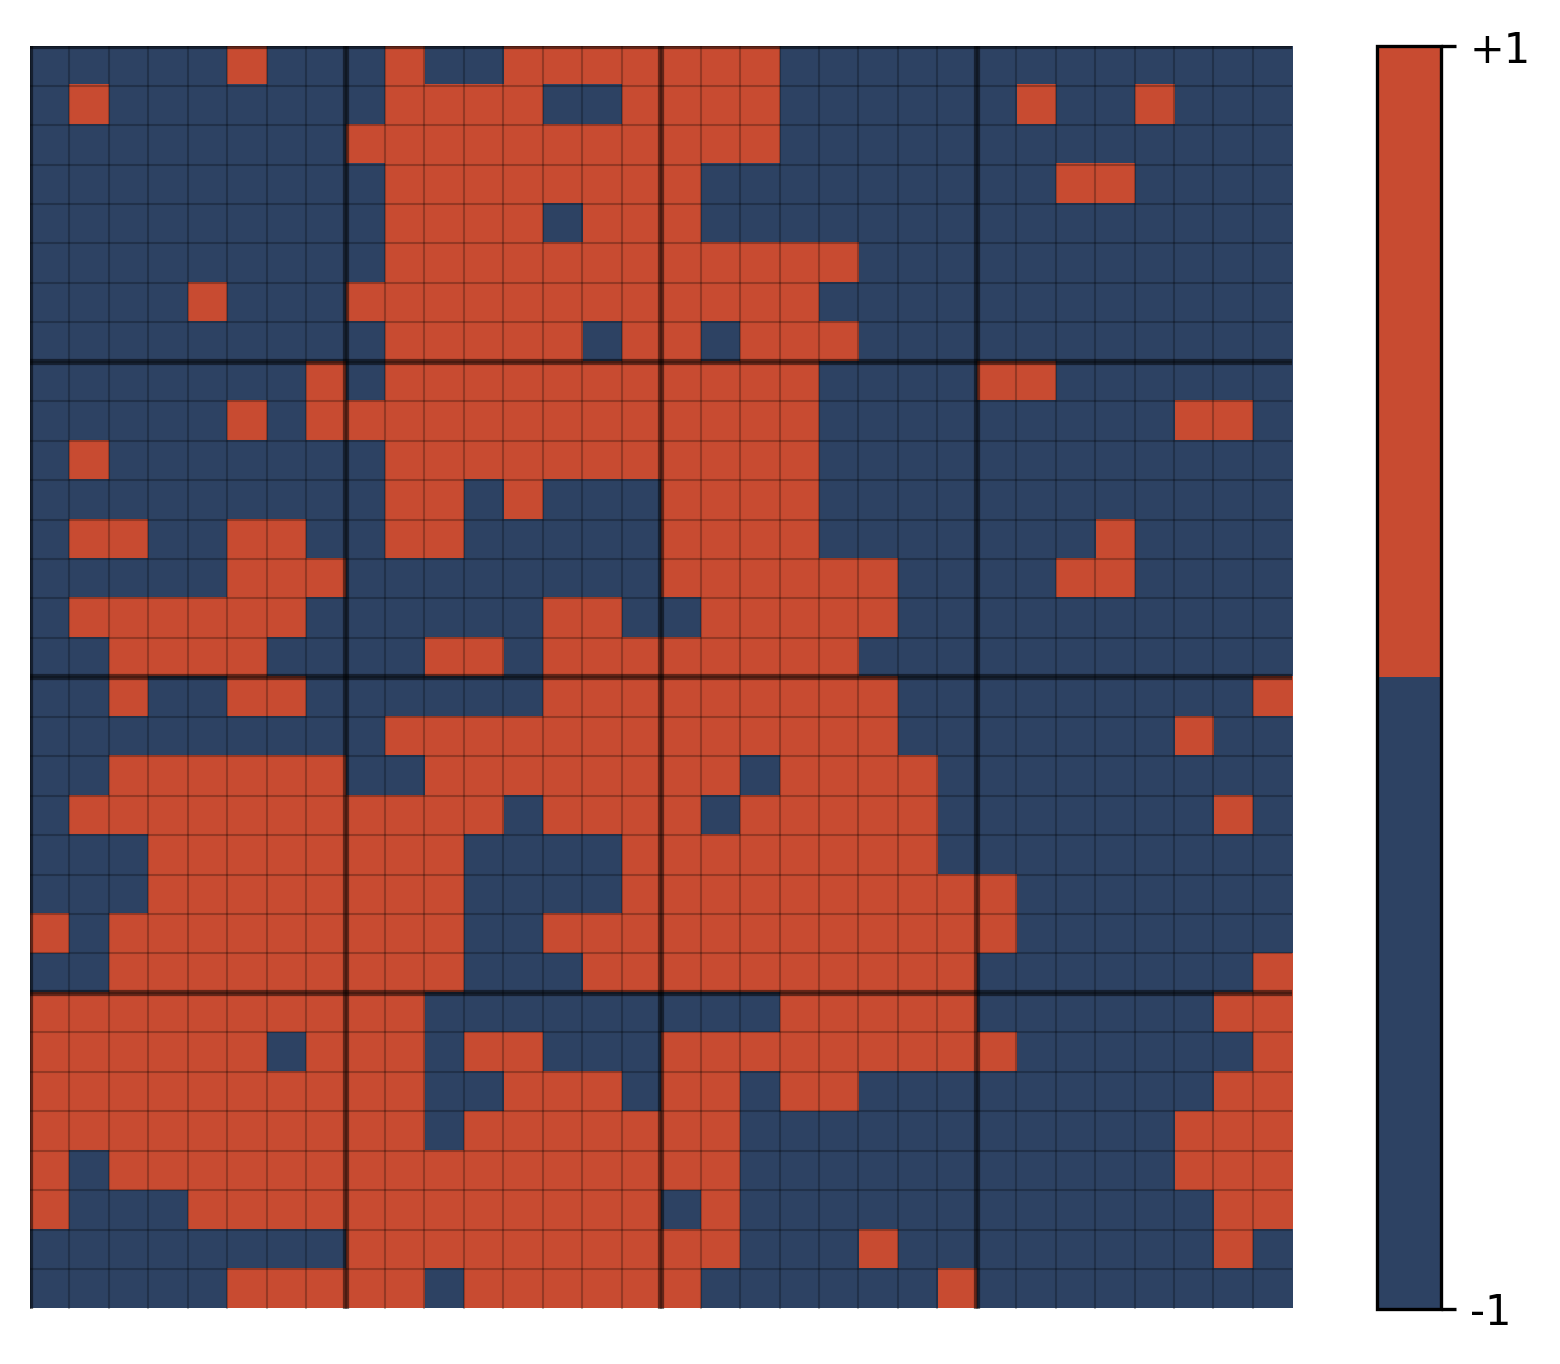

In [11]:
lattice.montecarlo(mc_steps, temperature)
lattice.show_lattice()

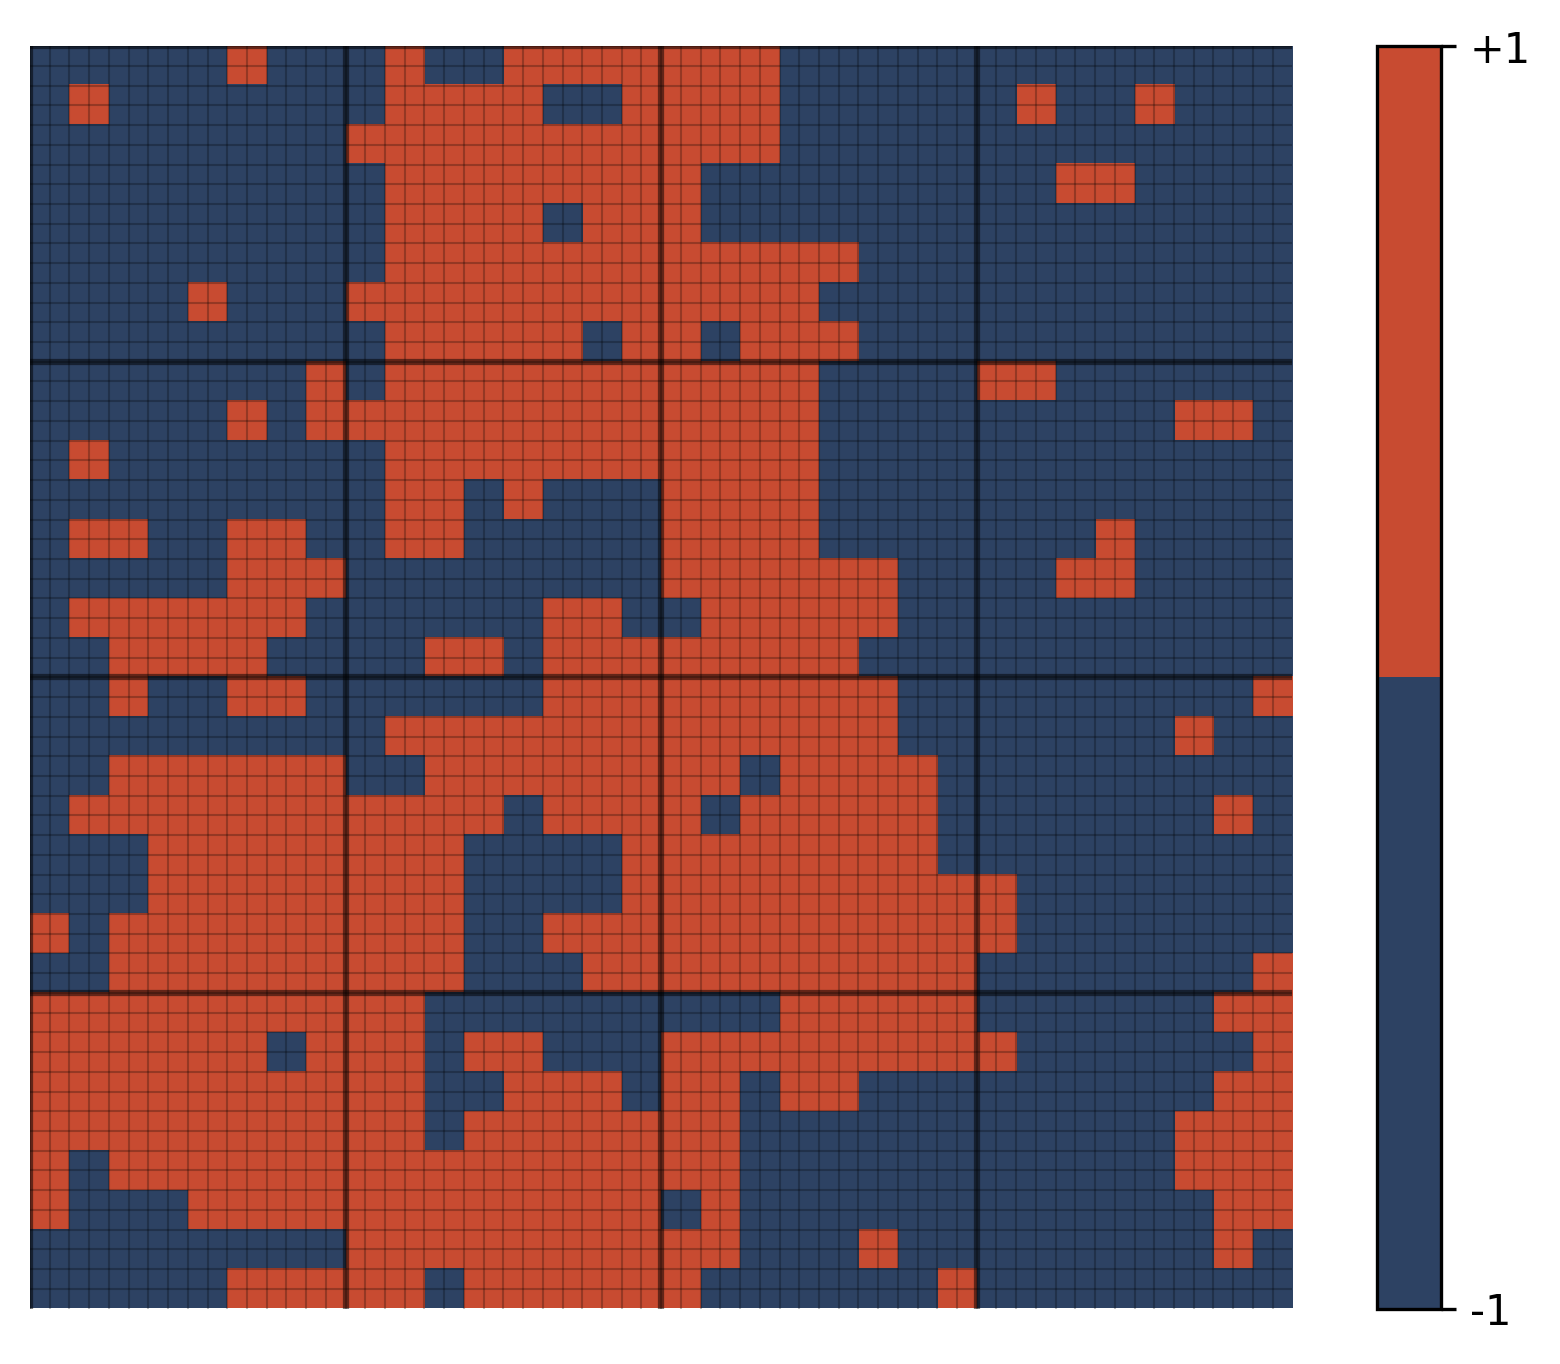

In [12]:
lattice.renorm()
lattice.show_lattice()

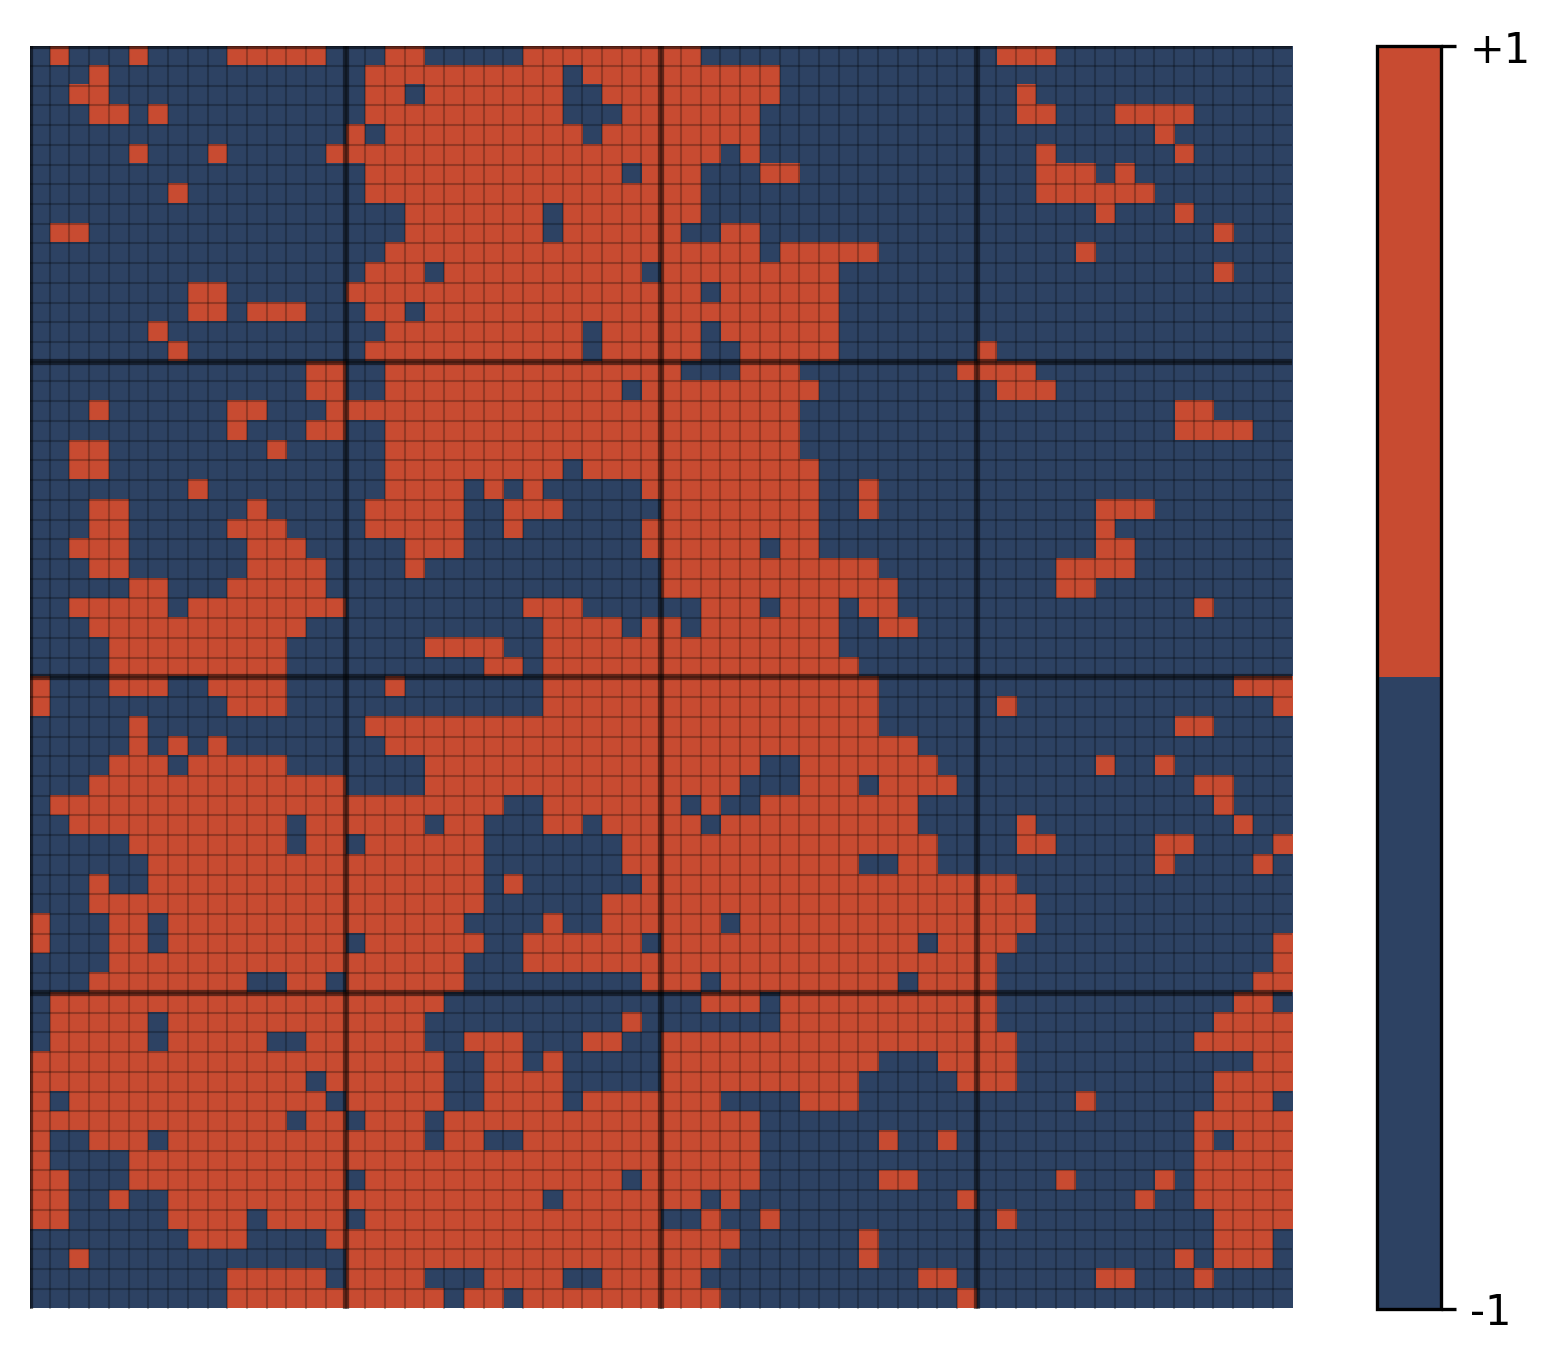

In [13]:
lattice.montecarlo(mc_steps, temperature)
lattice.show_lattice()

In [14]:
print(grid)

NameError: name 'grid' is not defined

In [81]:
x = np.linspace(-2 * np.pi, 2 * np.pi,200)

def update(frame):
  ax.clear()
  plt.imshow(lattice.lattice)
  #plt.plot(x,np.sin((x-(2 * np.pi * frame/nframes))))
  #plt.xlim([0, 2 * np.pi])
  #plt.ylim([-1.1, 1.1])
  
%matplotlib notebook
fig, ax = plt.subplots()
animation.FuncAnimation(fig, func=update, frames=10, interval=33)

<IPython.core.display.Javascript object>